In [10]:
try:
    import os
    import requests
    import networkx as nx
    import matplotlib.pyplot as plt
    from dotenv import load_dotenv

    load_dotenv('../Docs/.env')

except Exception as e:
    print(f"Error : {e}")

In [11]:
base_url = 'https://api.tfl.gov.uk'
app_key = os.getenv('app_key')

# Get all stations and their information
response = requests.get(f'{base_url}/StopPoint/Mode/tube?app_key={app_key}')
tube_stations = response.json()

In [12]:
# Step 1: Initialize the transport network graph
transport_network = nx.Graph()

In [13]:
# Step 2: Add nodes (stations) to the graph
stations = {
    'Baker Street': {'lines': ['Bakerloo', 'Jubilee']},
    'Oxford Circus': {'lines': ['Bakerloo', 'Central', 'Victoria']},
    'Green Park': {'lines': ['Jubilee', 'Piccadilly', 'Victoria']},
    'Bond Street': {'lines': ['Jubilee', 'Central']},
    'Waterloo': {'lines': ['Bakerloo', 'Jubilee', 'Northern']},
    'Westminster': {'lines': ['Jubilee', 'District', 'Circle']},
}

# Adding nodes to the graph
for station, attributes in stations.items():
    transport_network.add_node(station, **attributes)

In [14]:
# Step 3: Add edges (connections) to the graph
edges = [
    ('Baker Street', 'Oxford Circus', {'line': 'Bakerloo', 'distance': 1.0}),
    ('Oxford Circus', 'Green Park', {'line': 'Victoria', 'distance': 1.2}),
    ('Green Park', 'Bond Street', {'line': 'Jubilee', 'distance': 1.5}),
    ('Waterloo', 'Westminster', {'line': 'Jubilee', 'distance': 0.8}),
    ('Westminster', 'Bond Street', {'line': 'Jubilee', 'distance': 2.0}),
]

# Adding edges to the graph with attributes properly set
for edge in edges:
    transport_network.add_edge(edge[0], edge[1], **edge[2])

In [15]:
# Step 4: Check if the graph is connected
if nx.is_connected(transport_network):
    print("The graph is connected.")
else:
    print("The graph is NOT connected.")

The graph is connected.


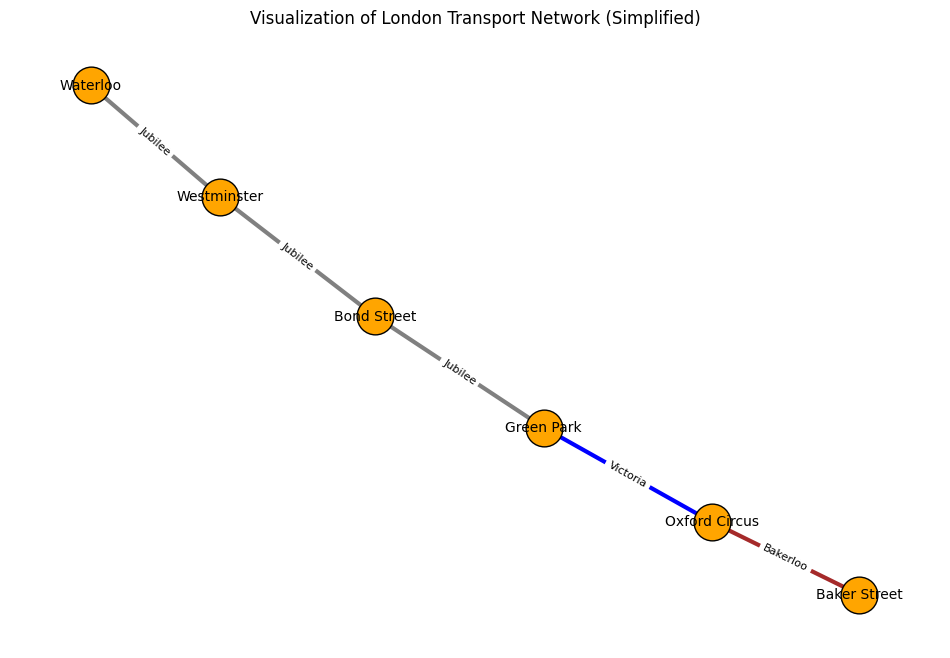

In [16]:
# Step 3: Visualize the Transport Network

# Define colors for different lines
colors = {
    'Bakerloo': 'brown',
    'Jubilee': 'gray',
    'Victoria': 'blue',
    'Central': 'red',
    'Piccadilly': 'purple',
    'District': 'green',
    'Circle': 'yellow'
}

# Extract edge colors based on line names
edge_colors = [colors[transport_network[u][v]['line']] for u, v in transport_network.edges()]

# Define the layout for visualization - using a spring layout for an organized visual
pos = nx.spring_layout(transport_network, seed=42)  # Set seed for consistent layout

# Draw the nodes (stations)
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(transport_network, pos, node_size=700, node_color='orange', edgecolors='black')

# Draw the edges with colors corresponding to transport lines
nx.draw_networkx_edges(transport_network, pos, edgelist=transport_network.edges(), edge_color=edge_colors, width=3)

# Draw labels for nodes (stations)
nx.draw_networkx_labels(transport_network, pos, font_size=10, font_family="sans-serif")

# Add line names as edge labels if needed
edge_labels = {(u, v): transport_network[u][v]['line'] for u, v in transport_network.edges()}
nx.draw_networkx_edge_labels(transport_network, pos, edge_labels=edge_labels, font_color='black', font_size=8)

plt.title("Visualization of London Transport Network (Simplified)")
plt.axis('off')  # Hide axis
plt.show()

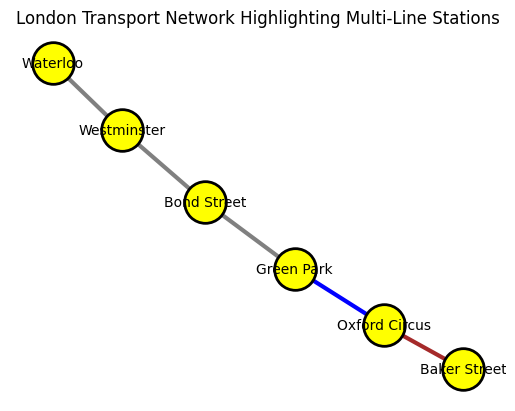

In [17]:
# Highlight nodes that belong to multiple lines
multi_line_stations = [node for node, attr in transport_network.nodes(data=True) if len(attr['lines']) > 1]

# Draw the nodes again, with special styling for multi-line stations
nx.draw_networkx_nodes(transport_network, pos, nodelist=multi_line_stations, node_size=900, node_color='yellow', edgecolors='black', linewidths=2)

# Rest of the visualization stays the same as above
nx.draw_networkx_nodes(transport_network, pos, nodelist=[n for n in transport_network if n not in multi_line_stations], node_size=700, node_color='orange')
nx.draw_networkx_edges(transport_network, pos, edgelist=transport_network.edges(), edge_color=edge_colors, width=3)
nx.draw_networkx_labels(transport_network, pos, font_size=10, font_family="sans-serif")

plt.title("London Transport Network Highlighting Multi-Line Stations")
plt.axis('off')
plt.show()

In [18]:
# Create graph
transport_network = nx.Graph()

# Get Tube line data
line_id = 'bakerloo'  # Example line
response = requests.get(f'{base_url}/Line/{line_id}/StopPoints?app_key={app_key}')
stations_data = response.json()

In [19]:
# Add stations to the graph
for station in stations_data:
    station_name = station['commonName']
    lat, lon = station['lat'], station['lon']
    transport_network.add_node(station_name, pos=(lon, lat), lines=[line_id])

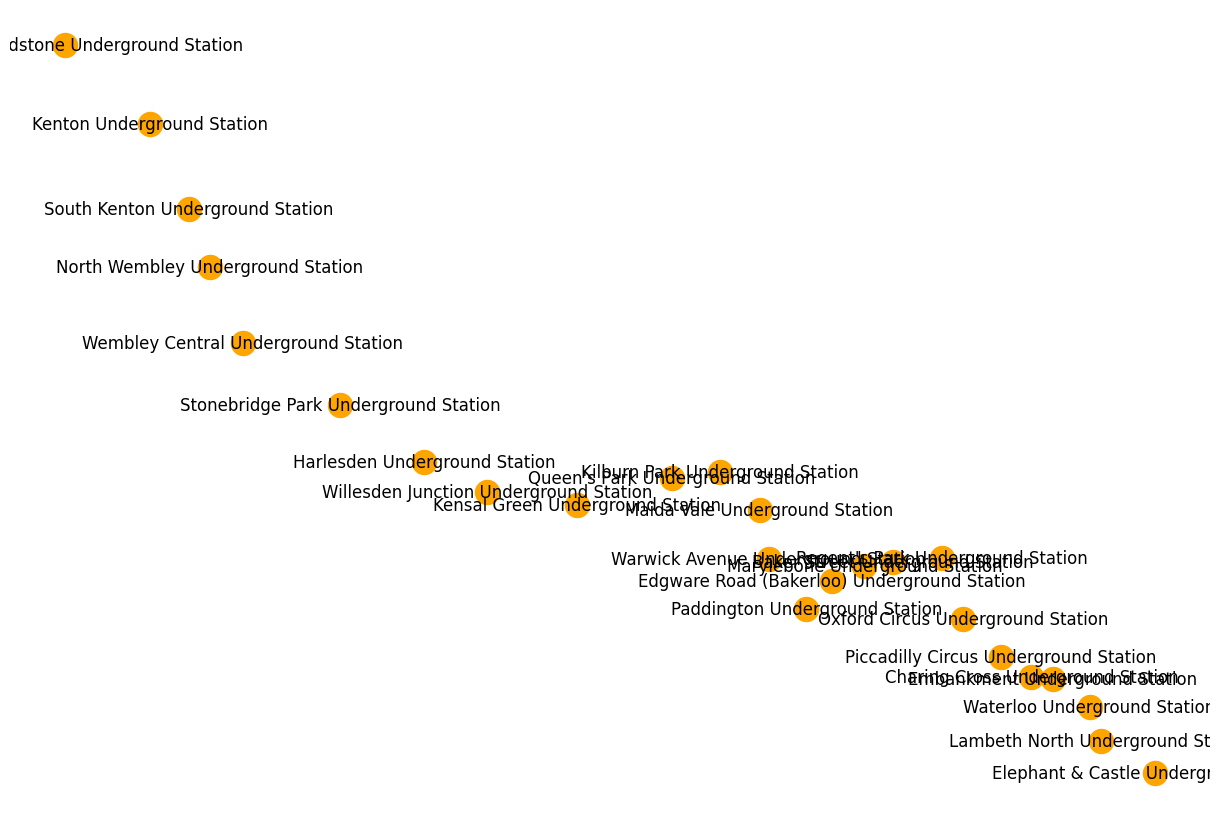

In [20]:
# Visualize (basic version)
pos = nx.get_node_attributes(transport_network, 'pos')
plt.figure(figsize=(12, 8))
nx.draw(transport_network, pos, with_labels=True, node_size=300, node_color='orange')
plt.show()